# EDA

## 1. Processing Data

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.impute import SimpleImputer

In [2]:
columns = [
    "C", "Si", "Mn", "S", "P", "Ni", "Cr", "Mo", "V", "Cu", "Co", "W",
    "O", "Ti", "N", "Al", "B", "Nb", "Sn", "As", "Sb",
    "Current", "Voltage", "AC_DC", "ElectrodePolarity", "HeatInput",
    "InterpassTemp", "WeldType", "PWHT_Temp", "PWHT_Time",
    "YieldStrength", "UTS", "Elongation", "ReductionArea",
    "CharpyTemp", "CharpyImpact", "Hardness", "FATT50", "PrimaryFerrite",
    "Ferrite2ndPhase", "AcicularFerrite", "Martensite", "FerriteCarbide",
    "WeldID"
]

In [3]:
df = pd.read_csv("../data/welddb.data", delim_whitespace=True, names=columns, na_values='N')
print(df.head())

       C    Si    Mn      S      P   Ni  Cr   Mo    V   Cu  ... CharpyTemp  \
0  0.037  0.30  0.65  0.008  0.012  0.0 NaN  NaN  NaN  NaN  ...        NaN   
1  0.037  0.30  0.65  0.008  0.012  0.0 NaN  NaN  NaN  NaN  ...      -28.0   
2  0.037  0.30  0.65  0.008  0.012  0.0 NaN  NaN  NaN  NaN  ...      -38.0   
3  0.037  0.31  1.03  0.007  0.014  0.0 NaN  NaN  NaN  NaN  ...        NaN   
4  0.037  0.31  1.03  0.007  0.014  0.0 NaN  NaN  NaN  NaN  ...      -48.0   

  CharpyImpact  Hardness FATT50 PrimaryFerrite Ferrite2ndPhase  \
0          NaN       NaN    NaN            NaN             NaN   
1        100.0       NaN    NaN            NaN             NaN   
2        100.0       NaN    NaN            NaN             NaN   
3          NaN       NaN    NaN            NaN             NaN   
4        100.0       NaN    NaN             32            28.0   

  AcicularFerrite Martensite FerriteCarbide                         WeldID  
0             NaN        NaN            NaN    Evans-Ni/C

C:\Users\clemm\AppData\Local\Temp\ipykernel_3636\366920719.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("../data/welddb.data", delim_whitespace=True, names=columns, na_values='N')


## 2. Cleaning and preprocessing

In [4]:
print(df.isna().sum())

C                       0
Si                      0
Mn                      0
S                       4
P                      10
Ni                    955
Cr                    868
Mo                    859
V                     724
Cu                   1074
Co                   1523
W                    1577
O                     396
Ti                    717
N                     410
Al                    747
B                    1148
Nb                    900
Sn                   1356
As                   1418
Sb                   1392
Current               248
Voltage               248
AC_DC                 215
ElectrodePolarity     156
HeatInput               0
InterpassTemp           0
WeldType                0
PWHT_Temp              13
PWHT_Time              13
YieldStrength         872
UTS                   914
Elongation            952
ReductionArea         947
CharpyTemp            773
CharpyImpact          773
Hardness             1514
FATT50               1621
PrimaryFerri

A lot of data is missing.

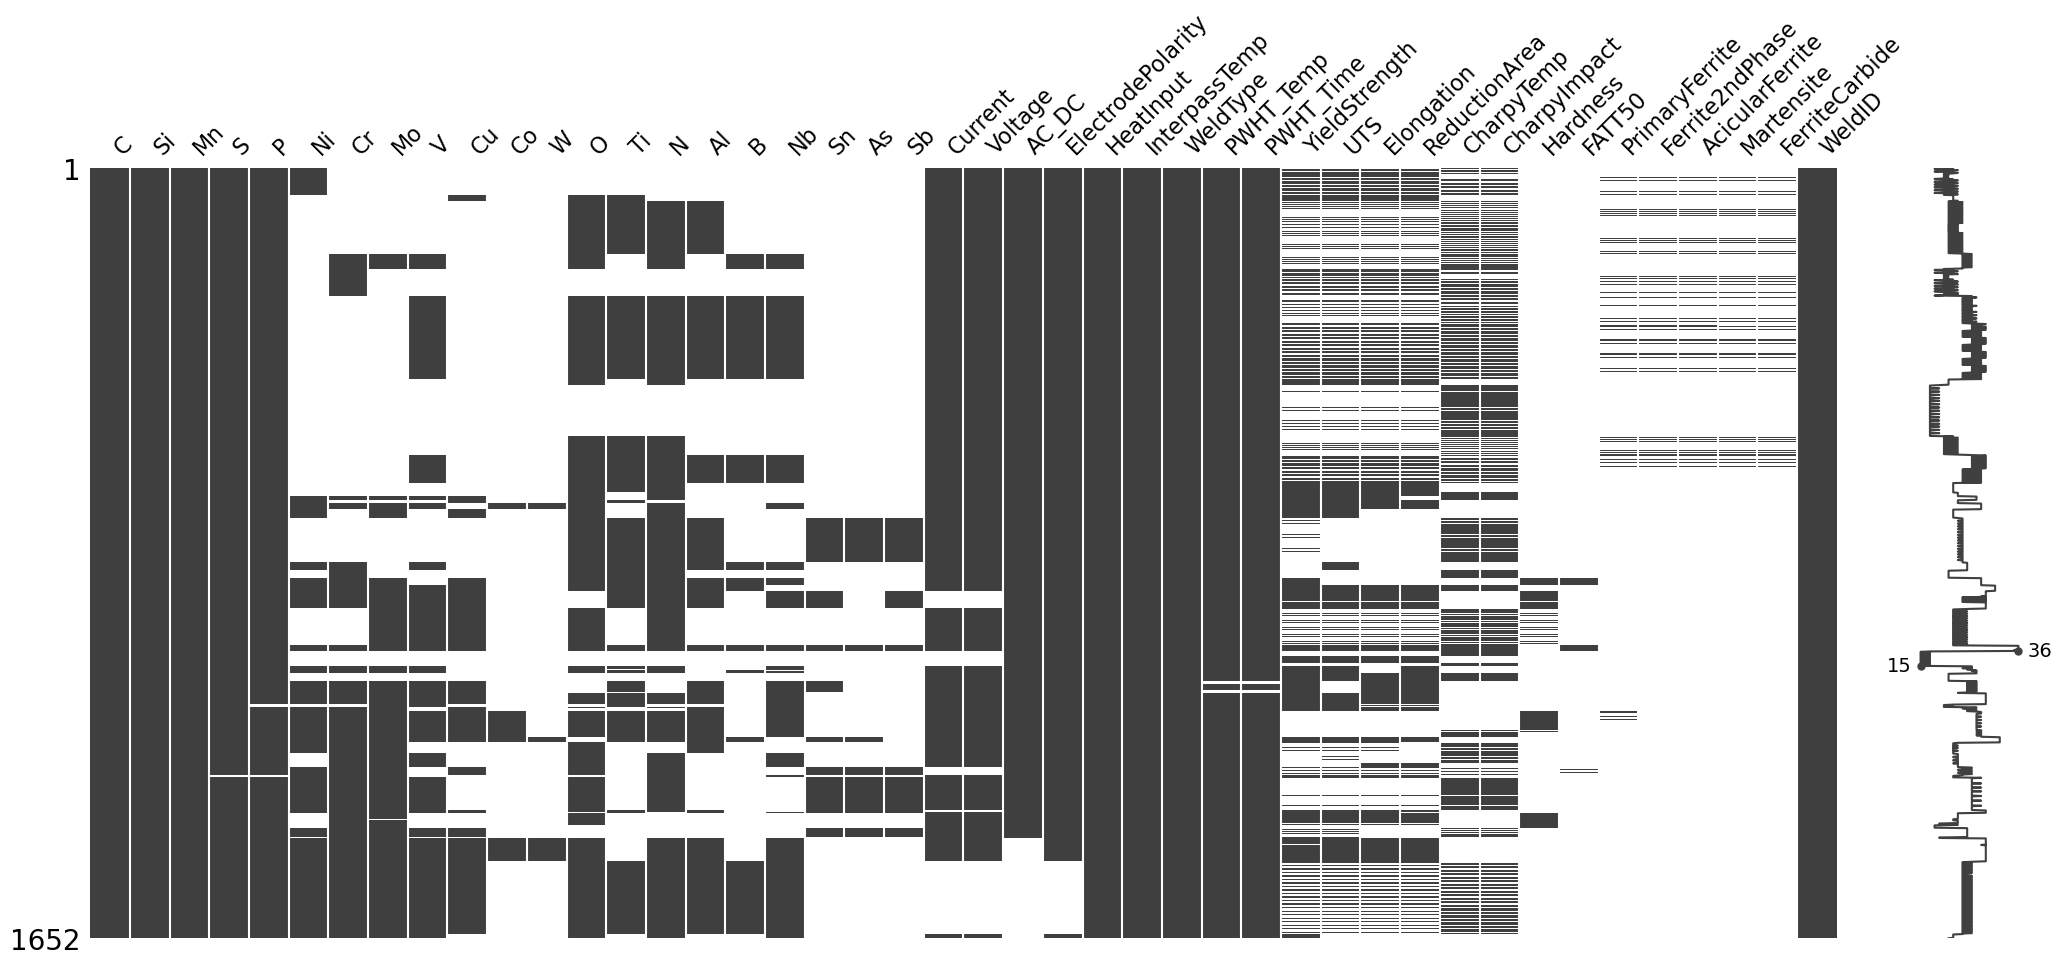

In [5]:
msno.matrix(df)
plt.show()

Interpretation:
- Each column = one variable (chemistry, process, mechanics, microstructure, etc.).
- Each row = one sample (one welding filler metal).
- Black = missing data, white = data present.

The bar on the right shows the number of missing values per row.

We can see:
- The first columns (C, Si, Mn, etc.) are almost entirely filled in.
- Columns such as Ti, Al, Nb, Sn, etc. have many missing values (probably because they were not measured in certain studies).
- Mechanical properties (YS, UTS, elongation, etc.) are partially available.
- The microstructure (ferrite, martensite, etc.) is very incomplete.

In [6]:
print(df.dtypes)

C                    float64
Si                   float64
Mn                   float64
S                     object
P                    float64
Ni                   float64
Cr                   float64
Mo                    object
V                     object
Cu                    object
Co                    object
W                     object
O                    float64
Ti                    object
N                     object
Al                    object
B                     object
Nb                    object
Sn                    object
As                    object
Sb                    object
Current              float64
Voltage              float64
AC_DC                 object
ElectrodePolarity     object
HeatInput            float64
InterpassTemp         object
WeldType              object
PWHT_Temp            float64
PWHT_Time            float64
YieldStrength        float64
UTS                  float64
Elongation           float64
ReductionArea        float64
CharpyTemp    

Finding whether they are MNAR, MAR, MCAR:

We keep for this step only the numerical values:

In [9]:
df_num = df.select_dtypes(include=np.number)

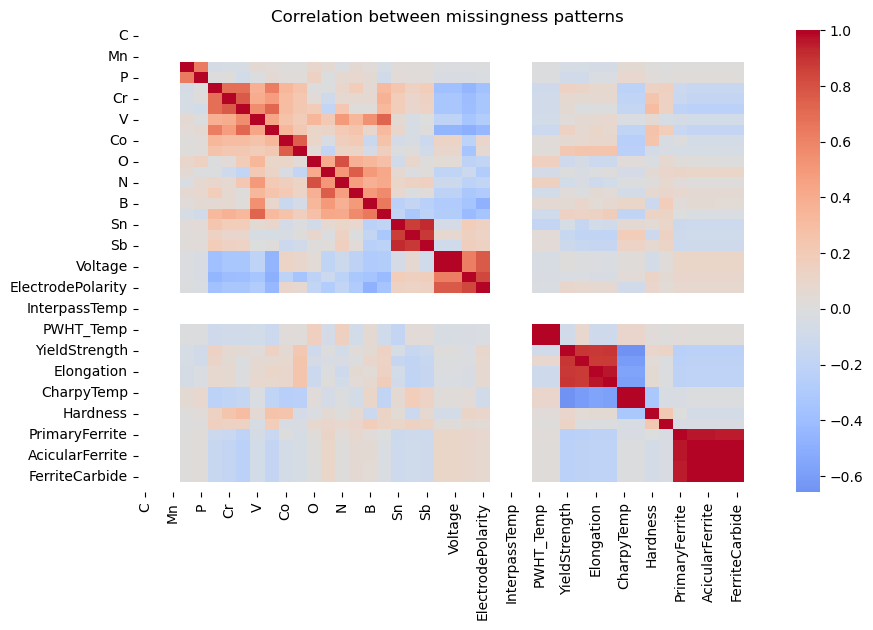

In [12]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isna().corr(), cmap="coolwarm", center=0)
plt.title("Correlation between missingness patterns")
plt.show()

Thus we can try to intute patterns MAR, MCAR and MNAR:
- **MCAR**: correlations in the heatmap are close to 0 everywhere
- **MAR**: strong correlations between patterns of missing data
- **MNAR**: difficult to prove directly

Thus:
- **Chemical elements** (C, Mn, Cr, etc.) might be **MAR** : Correlated missing data between elements: depends on the analytical protocol
- **Mechanical properties** (YieldStrength, UTS, Elongation, etc.) might be **MAR** as well: Data missing together, therefore related to the availability of mechanical tests.
- **Microstructure** (PrimaryFerrite, AcicularFerrite, FerriteCarbide) might be **MNAR**: Probably absent when the microstructure is complex or not measured (non-random).
- **Process parameters** (Voltage, Polarity, InterpassTemp) might be **MCAR** or quasi-MCAR: Little or no correlation with other patterns of missing data.

### MCAR (Missing Completely at Random)

Values are missing without any particular logic: they can be deleted or simply imputed.

**Strategy**:
- If there is little missing data (<5%), you can delete the relevant rows (dropna).
- Otherwise, simple imputation: mean or median (SimpleImputer(strategy=‘median’))..

In [16]:
df.columns

Index(['C', 'Si', 'Mn', 'S', 'P', 'Ni', 'Cr', 'Mo', 'V', 'Cu', 'Co', 'W', 'O',
       'Ti', 'N', 'Al', 'B', 'Nb', 'Sn', 'As', 'Sb', 'Current', 'Voltage',
       'AC_DC', 'ElectrodePolarity', 'HeatInput', 'InterpassTemp', 'WeldType',
       'PWHT_Temp', 'PWHT_Time', 'YieldStrength', 'UTS', 'Elongation',
       'ReductionArea', 'CharpyTemp', 'CharpyImpact', 'Hardness', 'FATT50',
       'PrimaryFerrite', 'Ferrite2ndPhase', 'AcicularFerrite', 'Martensite',
       'FerriteCarbide', 'WeldID'],
      dtype='object')

In [18]:
process_param_columns = ['Current', 'Voltage','AC_DC', 'ElectrodePolarity', 'HeatInput', 'InterpassTemp', 'WeldType', 'PWHT_Temp', 'PWHT_Time']
print("Percentage of missing values:\n", df[process_param_columns].isna().sum()/df[process_param_columns].count())

Percentage of missing values:
 Current              0.176638
Voltage              0.176638
AC_DC                0.149617
ElectrodePolarity    0.104278
HeatInput            0.000000
InterpassTemp        0.000000
WeldType             0.000000
PWHT_Temp            0.007932
PWHT_Time            0.007932
dtype: float64


In [20]:
# Numeric columns to impute with median
num_cols = ['Current', 'Voltage']
num_imputer = SimpleImputer(strategy='median')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# Categorical columns to impute with mode
cat_cols = ['AC_DC', 'ElectrodePolarity']
cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# Columns with very low missing data (<1%) - optional to drop
df.dropna(subset=['PWHT_Temp', 'PWHT_Time'], inplace=True)

### MAR (Missing At Random)

Chemical composition have missing values which depends on analytical protocol (e.g., some elements measured together).

**Strategy**:
- Use multivariate imputation that leverages relationships between chemical elements
- Alternatively, use KNN imputation if we expect local similarity between alloys

In [42]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [41]:
chem_cols = ['C', 'Si', 'Mn', 'S', 'P', 'Ni', 'Cr', 'Mo', 'V', 'Cu', 'Co', 'W', 'O','Ti', 'N', 'Al', 'B', 'Nb', 'Sn', 'As', 'Sb']

In [30]:
non_numeric = df[chem_cols].select_dtypes(include='object').columns

In [37]:
df[chem_cols] = df[chem_cols].replace(',', '.', regex=True)
df[chem_cols] = df[chem_cols].replace(r'[<>]|ND|nd|Na|NA', '', regex=True)
df[chem_cols] = df[chem_cols].apply(pd.to_numeric, errors='coerce')

In [43]:
imp = IterativeImputer(random_state=0)
df[chem_cols] = imp.fit_transform(df[chem_cols])

In [46]:
df[chem_cols].head()

,C,Si,Mn,S,P,Ni,Cr,Mo,V,Cu,...,W,O,Ti,N,Al,B,Nb,Sn,As,Sb
0,0.037,0.30,0.65,0.008,0.012,0.0,2.189899,0.618717,0.074500,0.203616,...,0.085422,443.125592,80.384739,116.852837,64.058067,10.452024,146.503829,50.226706,38.279413,21.883806
1,0.037,0.30,0.65,0.008,0.012,0.0,2.189899,0.618717,0.074500,0.203616,...,0.085422,443.125592,80.384739,116.852837,64.058067,10.452024,146.503829,50.226706,38.279413,21.883806
2,0.037,0.30,0.65,0.008,0.012,0.0,2.189899,0.618717,0.074500,0.203616,...,0.085422,443.125592,80.384739,116.852837,64.058067,10.452024,146.503829,50.226706,38.279413,21.883806
3,0.037,0.31,1.03,0.007,0.014,0.0,1.758652,0.504925,0.075191,0.192290,...,0.163458,442.823038,81.431936,115.045512,78.110745,9.952040,131.027189,50.292401,37.489562,23.024268
4,0.037,0.31,1.03,0.007,0.014,0.0,1.758652,0.504925,0.075191,0.192290,...,0.163458,442.823038,81.431936,115.045512,78.110745,9.952040,131.027189,50.292401,37.489562,23.024268


Mechanical properties (e.g., YieldStrength, UTS, Elongation, ImpactEnergy, Hardness, etc.) are missing altogether when mechanical tests have not been performed.
Therefore, their values are correlated with each other:

**Strategy**:
- Multivariate imputation 

In [52]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [47]:
df.columns

Index(['C', 'Si', 'Mn', 'S', 'P', 'Ni', 'Cr', 'Mo', 'V', 'Cu', 'Co', 'W', 'O',
       'Ti', 'N', 'Al', 'B', 'Nb', 'Sn', 'As', 'Sb', 'Current', 'Voltage',
       'AC_DC', 'ElectrodePolarity', 'HeatInput', 'InterpassTemp', 'WeldType',
       'PWHT_Temp', 'PWHT_Time', 'YieldStrength', 'UTS', 'Elongation',
       'ReductionArea', 'CharpyTemp', 'CharpyImpact', 'Hardness', 'FATT50',
       'PrimaryFerrite', 'Ferrite2ndPhase', 'AcicularFerrite', 'Martensite',
       'FerriteCarbide', 'WeldID'],
      dtype='object')

In [48]:
mech_cols = [
    'YieldStrength', 'UTS', 'Elongation', 'ReductionArea',
    'CharpyTemp', 'CharpyImpact', 'Hardness', 'FATT50'
]

Before imputing, we create a binary feature indicating whether a mechanical test has been performed:

In [49]:
df['MechanicalTestDone'] = (~df[mech_cols].isna().all(axis=1)).astype(int)

In [51]:
df['MechanicalTestDone'].describe()

count    1639.000000
mean        0.968883
std         0.173686
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: MechanicalTestDone, dtype: float64

Hardness seems to have units :
- ex: 246Hv10, 144(Hv30), 212Hv10

Hardness Units:
| Scale  | Meaning          | Approximate unit |
| ------ | ---------------- | ---------------- |
| HV     | Vickers Hardness | kgf/mm²          |
| HB     | Brinell Hardness | kgf/mm²          |
| HRC    | Rockwell C       | relative scale   |
| HRB    | Rockwell B       | relative scale   |
| kg/mm² | direct unit      | equivalent to HV |

Since we only have HV values (Hv5, Hv10, Hv30), there’s no need for unit conversion. These are all Vickers hardness values, just measured with different indenter loads. Thus we can just strip the unit:

In [83]:
df['Hardness'] = (
    df['Hardness'].astype(str)
    .str.extract(r'([0-9]*\.?[0-9]+)')[0]  # take only the number
    .astype(float)
)

In [84]:
imp_mech = IterativeImputer(random_state=0, max_iter=10)
df[mech_cols] = imp_mech.fit_transform(df[mech_cols])

In [85]:
df[mech_cols]

,YieldStrength,UTS,Elongation,ReductionArea,CharpyTemp,CharpyImpact,Hardness,FATT50
0,392.000000,466.000000,31.900000,80.600000,-62.340600,100.437073,167.793989,-31.606895
1,539.480878,595.361724,24.368108,73.790987,-28.000000,100.000000,709.271474,-30.930308
2,370.000000,456.000000,35.200000,80.600000,-38.000000,100.000000,859.509579,-30.955908
3,413.000000,498.000000,31.200000,80.600000,-56.406404,96.586268,181.983998,-31.490512
4,577.170399,599.082061,25.135567,78.553386,-48.000000,100.000000,354.142979,-31.418184
...,...,...,...,...,...,...,...,...
1647,834.000000,667.602345,20.857861,94.537711,-86.813971,120.767143,319.270652,-32.556854
1648,822.000000,665.023941,21.058350,93.720445,-84.914582,119.560904,315.065070,-32.500969
1649,660.000000,630.215482,23.764950,82.687356,-59.272823,103.276665,258.289714,-31.746528
1650,832.000000,667.172611,20.891275,94.401500,-86.497406,120.566103,318.569721,-32.547540


### MNAR (Missing Not At Random)

Microstructure columns, which are likely MNAR (Missing Not At Random). That means:

The missingness depends on the data itself.

Example: If the microstructure is complex, certain features may simply not be measured.

In [ ]:
micro_cols = [
    'PrimaryFerrite', 'Ferrite2ndPhase', 'AcicularFerrite',
    'Martensite', 'FerriteCarbide'
]

We shouldn’t blindly impute MNAR values, because filling them in with “typical” numbers can introduce bias.

So we'll leave them as is and change them only if the chosen model can't handle missing values and we'll then add a missingness indicator : a flag column (0/1) telling the model whether any microstructure info is missing: missingness itself becomes a useful feature

In [87]:
df.to_csv('dataset_cleaned_2025_10_18.csv', index=False)

## 3. Outlier detection

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

In [93]:
numeric_cols = df.select_dtypes(include=['float64']).columns.tolist()

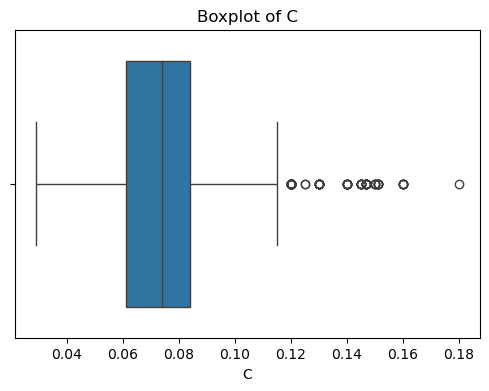

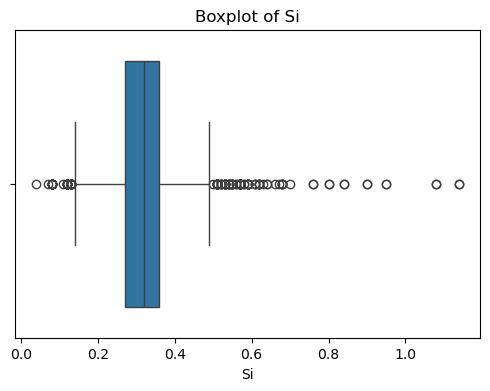

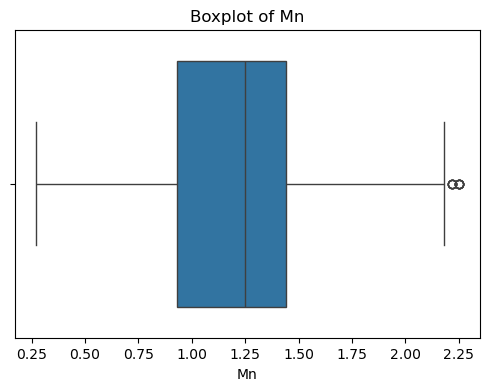

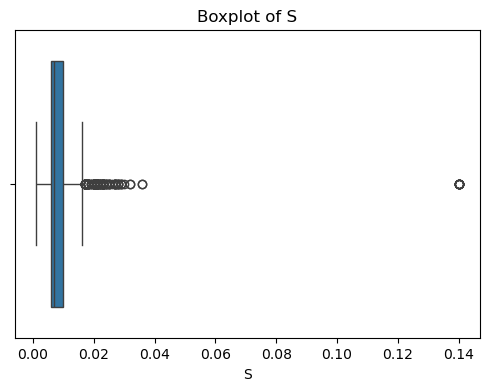

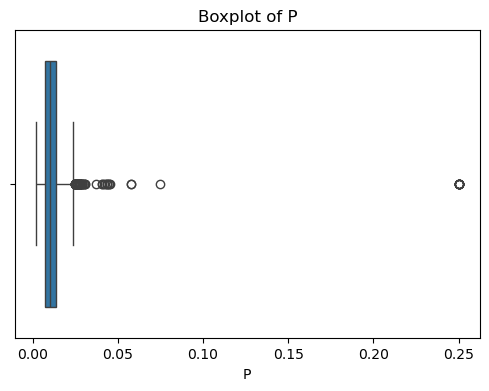

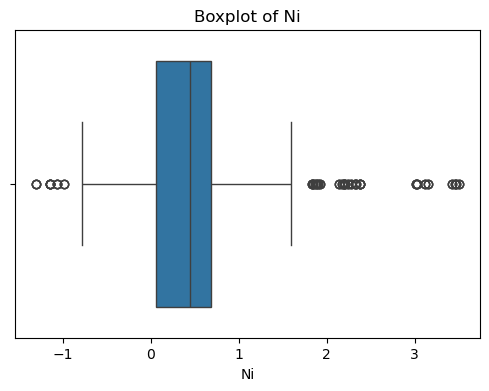

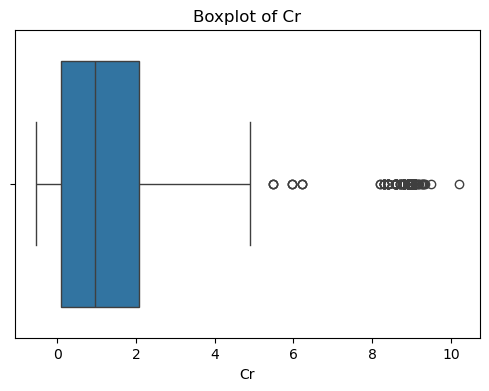

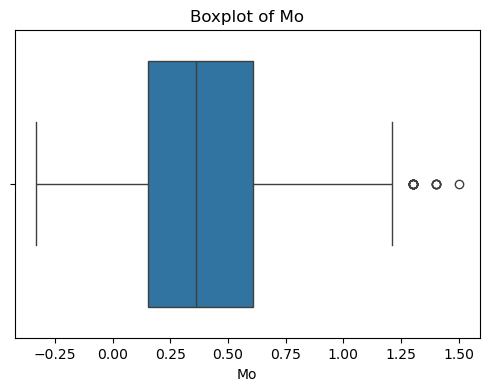

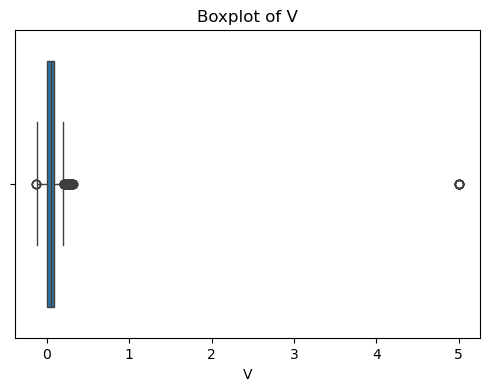

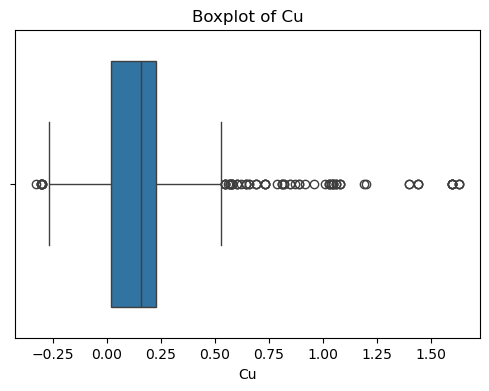

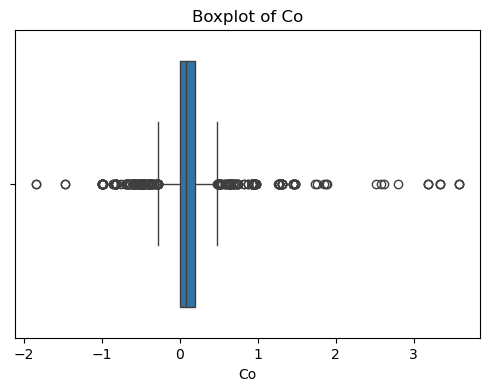

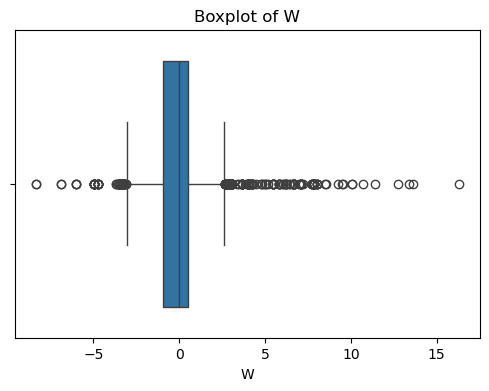

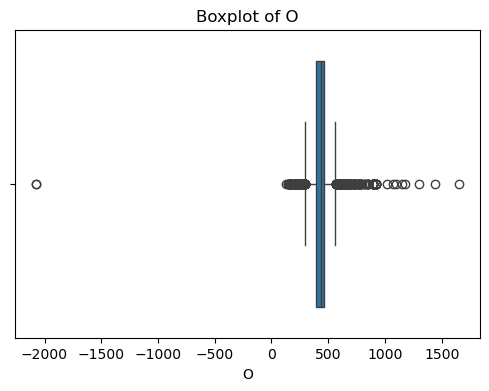

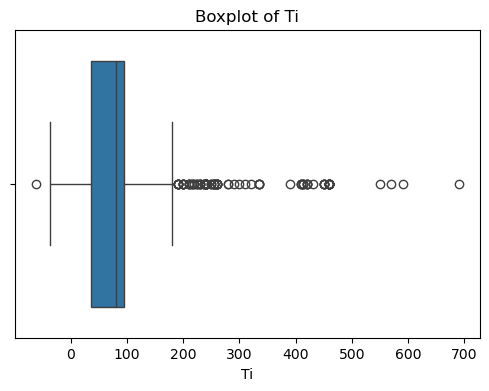

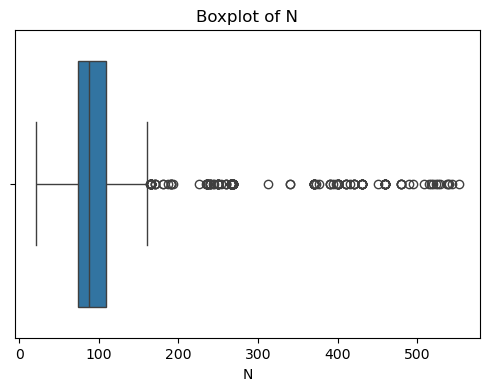

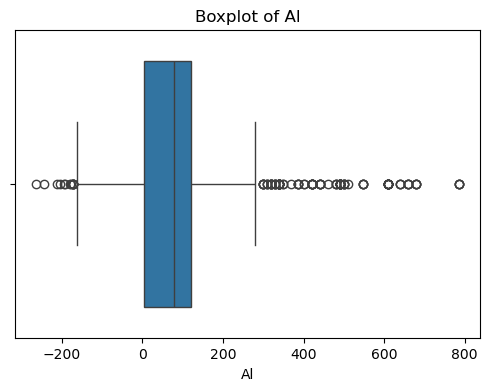

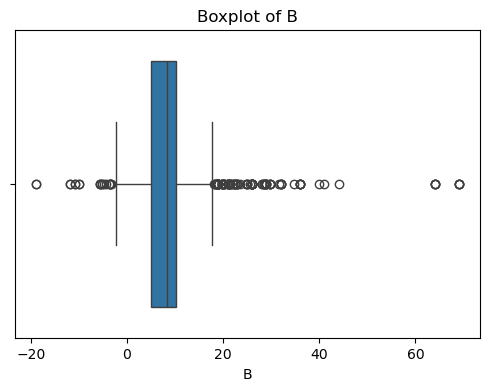

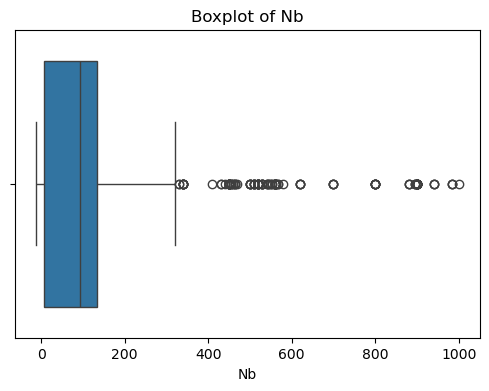

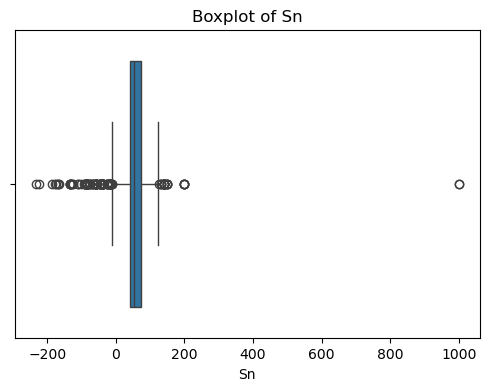

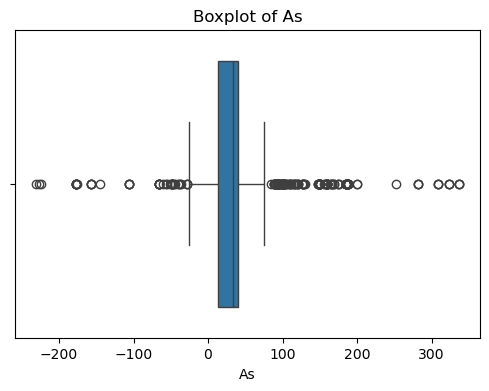

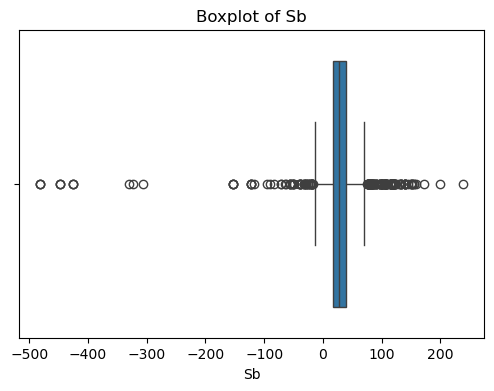

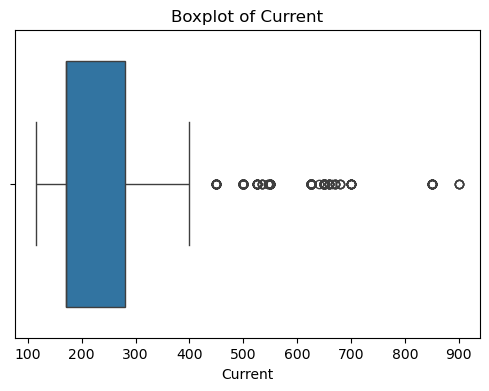

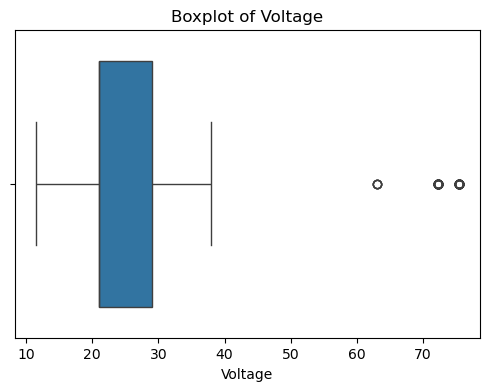

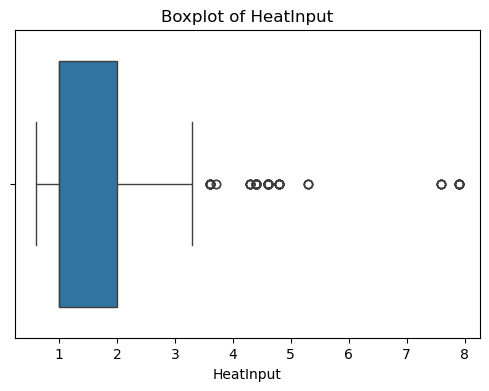

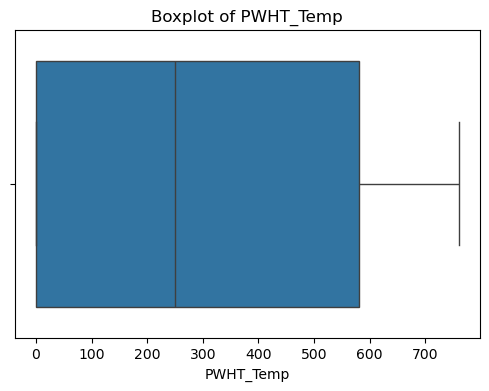

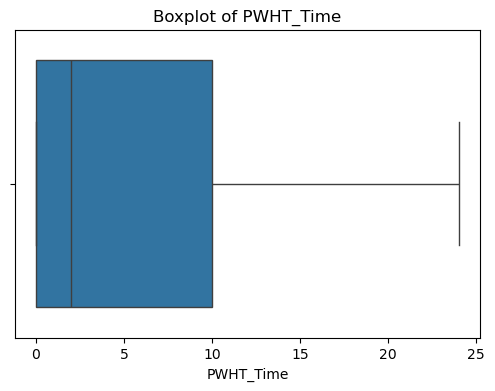

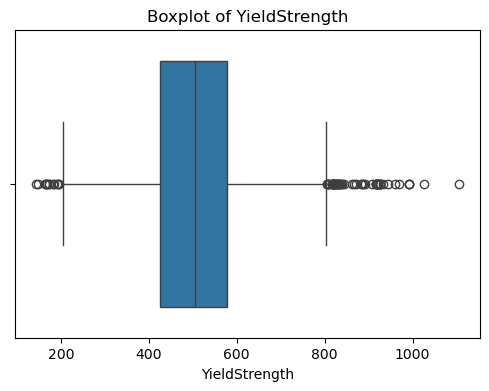

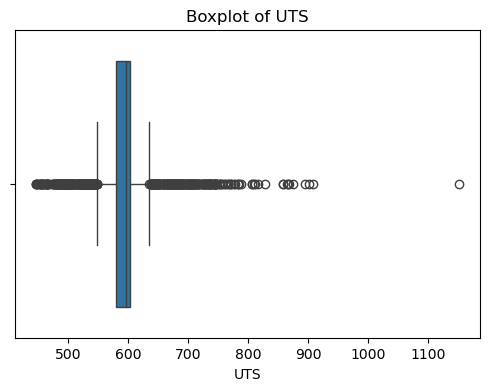

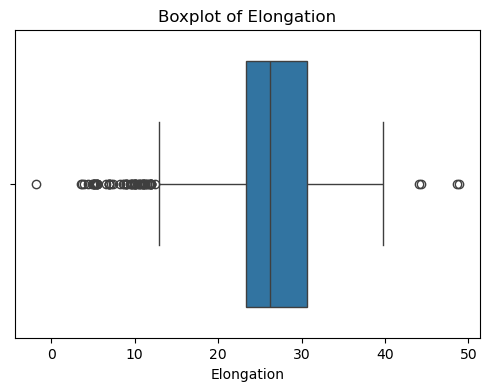

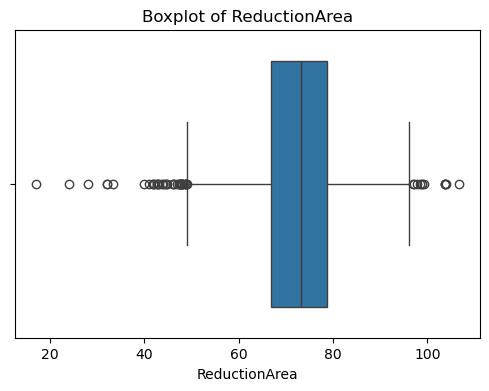

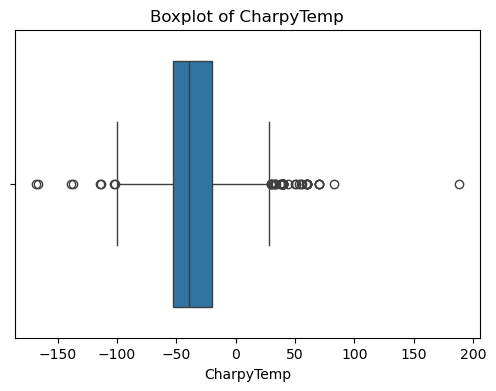

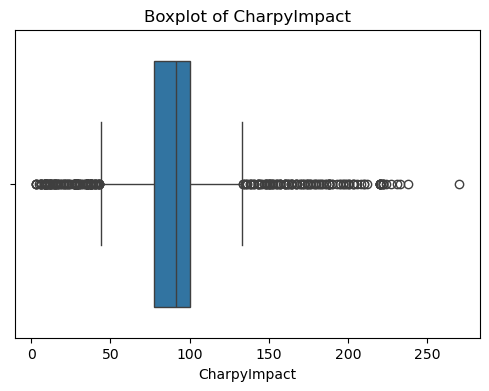

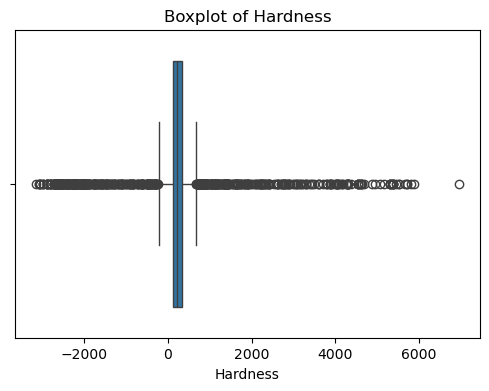

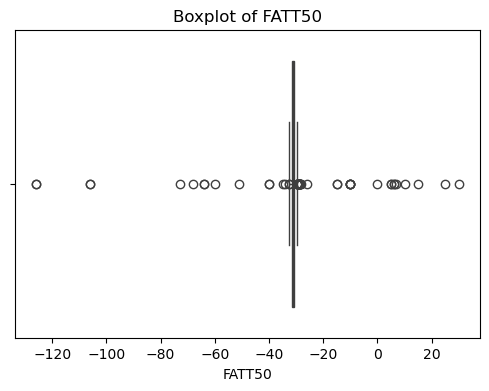

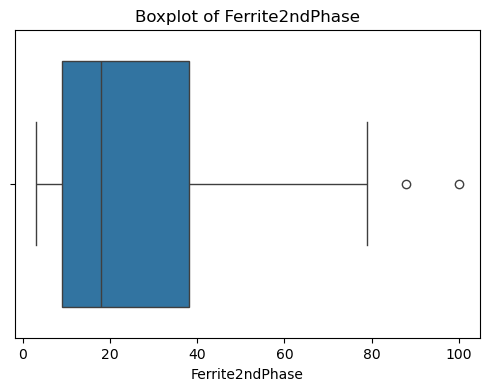

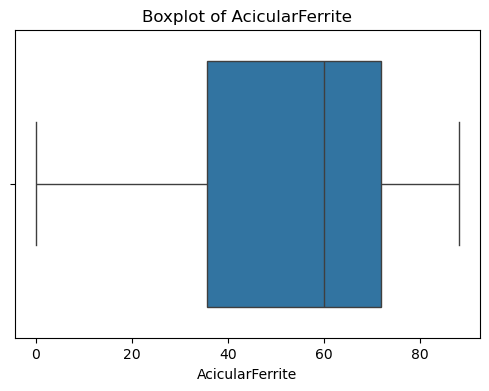

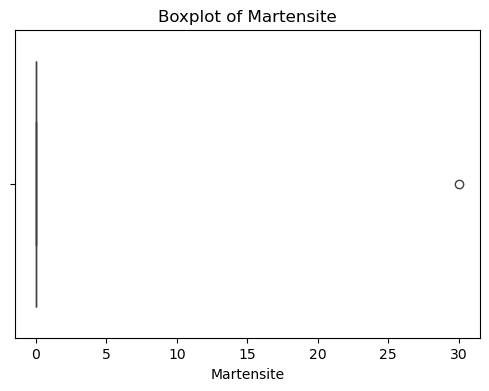

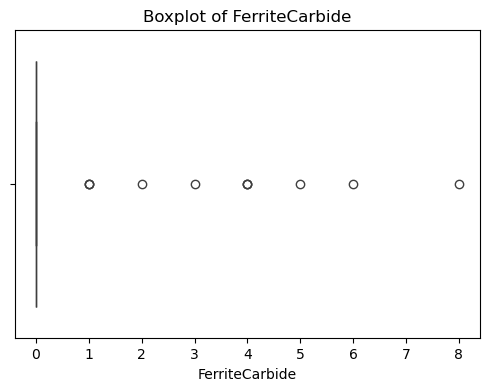

In [94]:
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


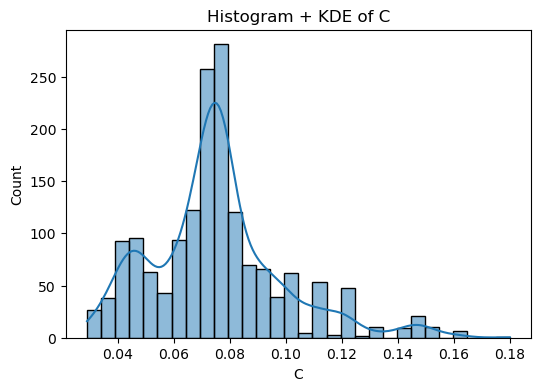

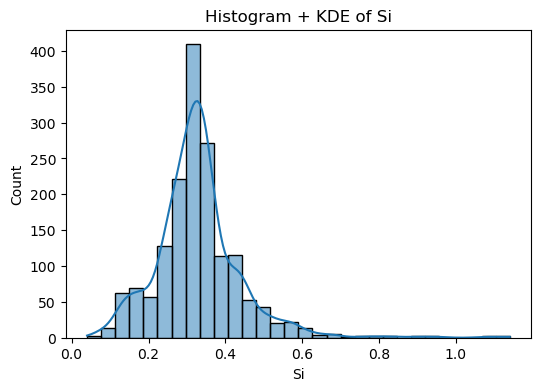

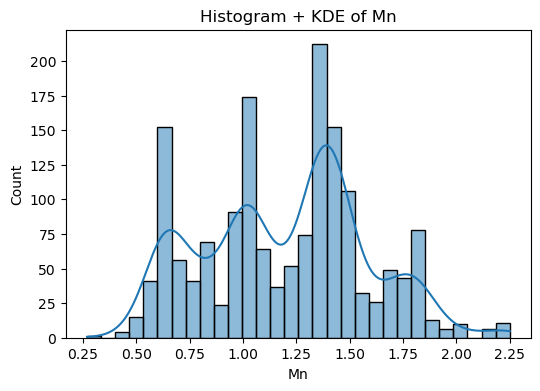

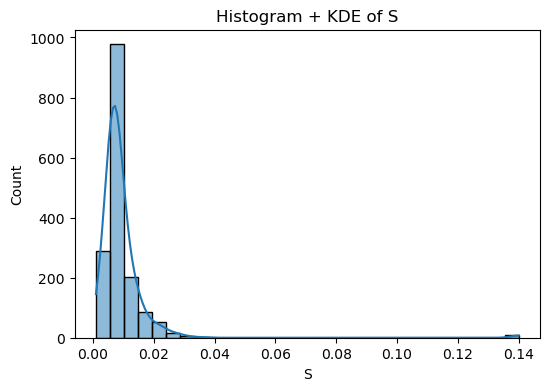

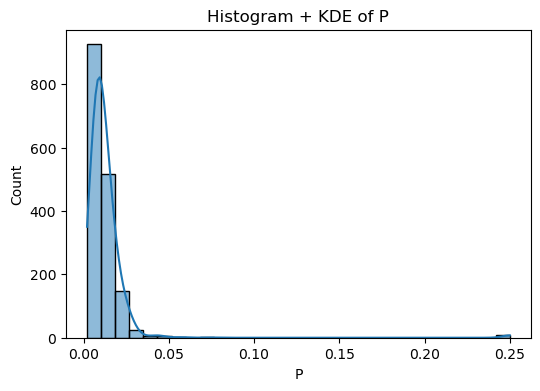

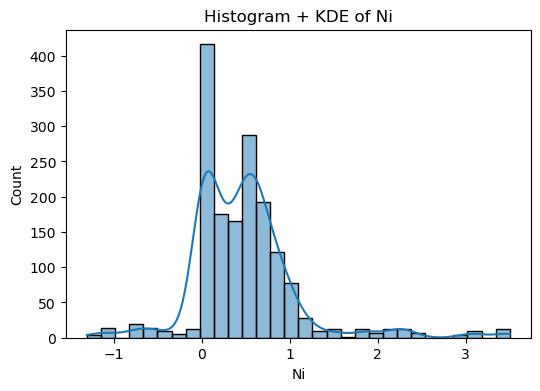

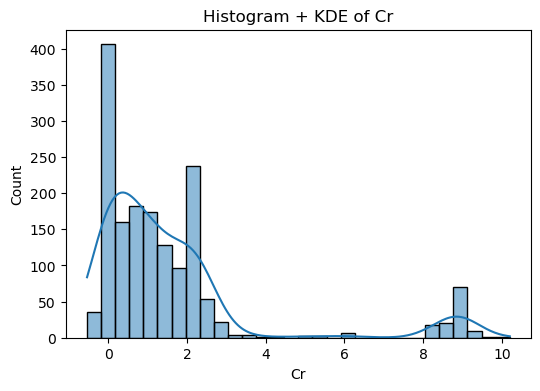

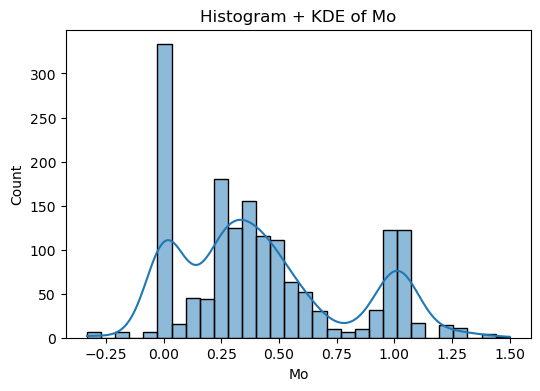

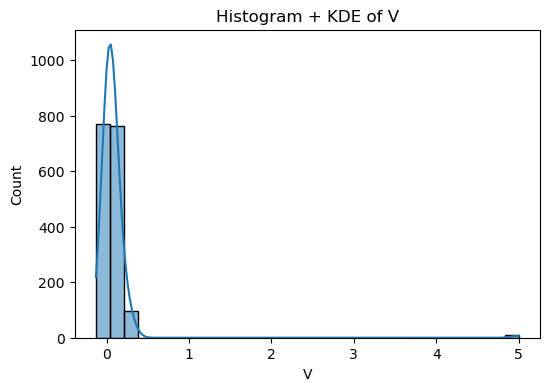

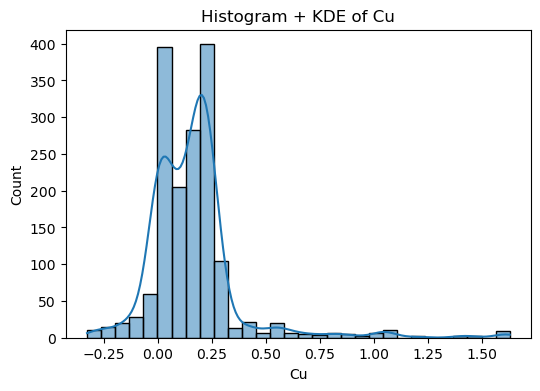

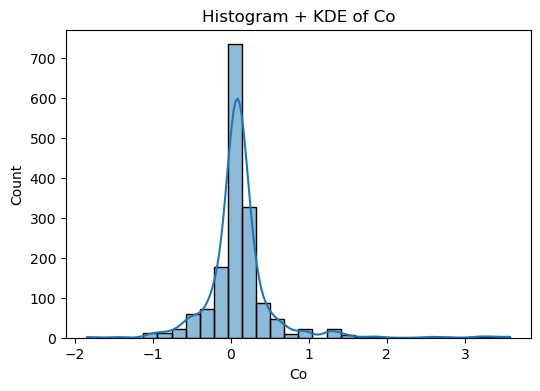

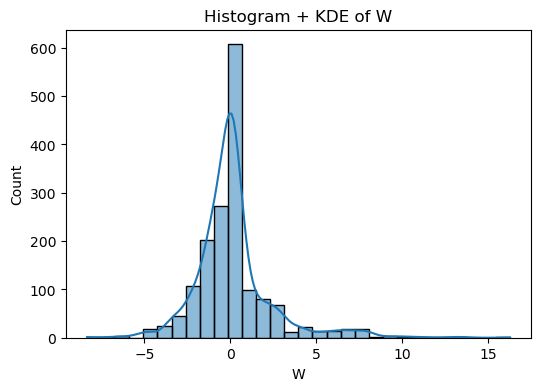

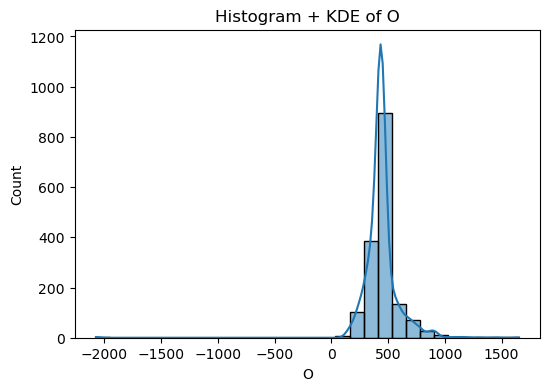

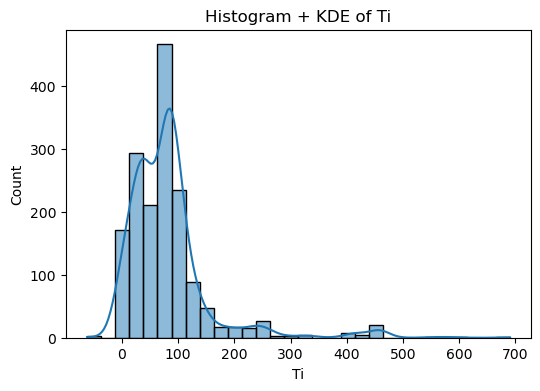

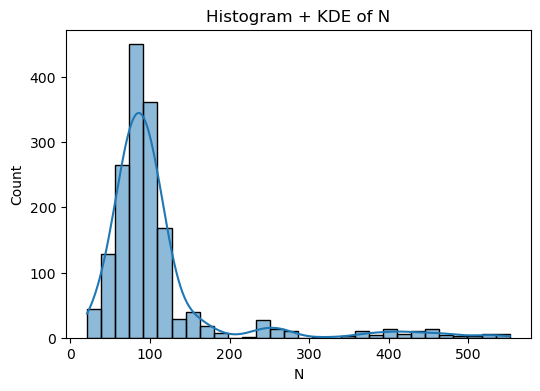

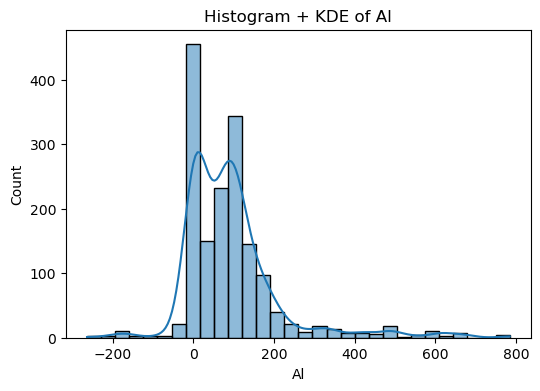

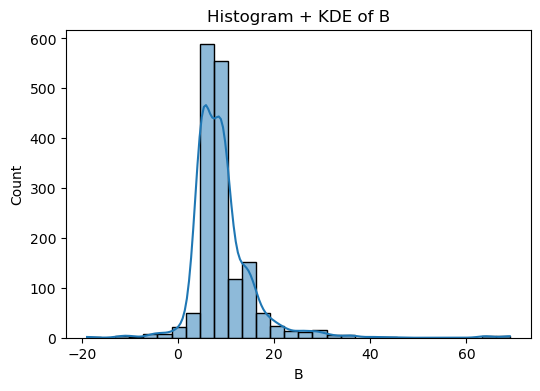

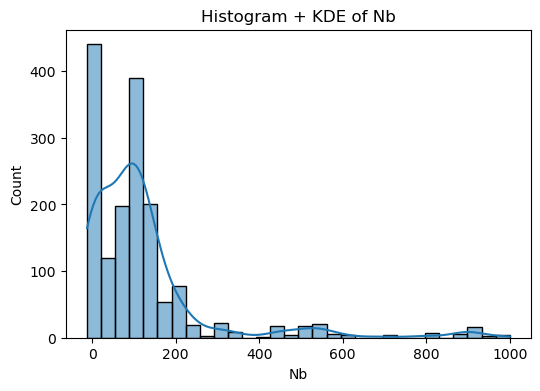

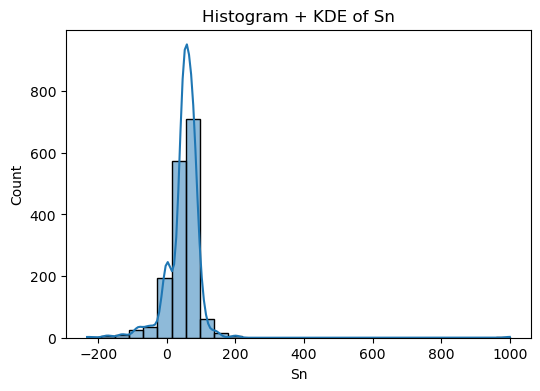

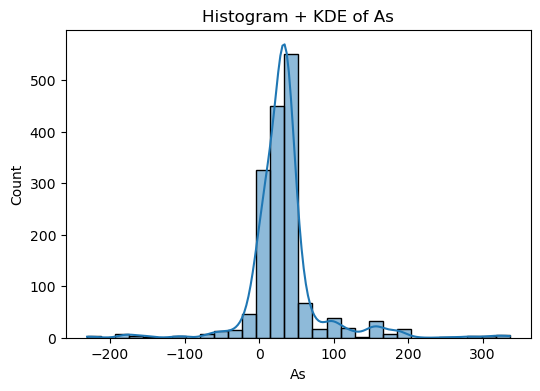

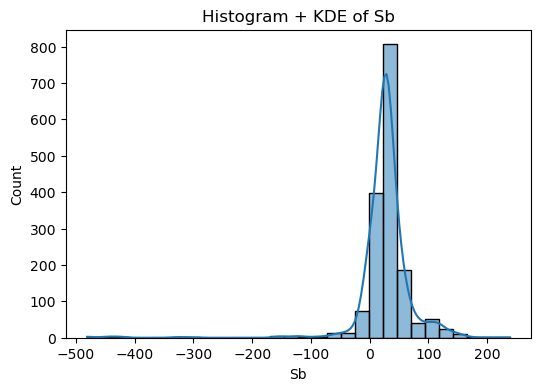

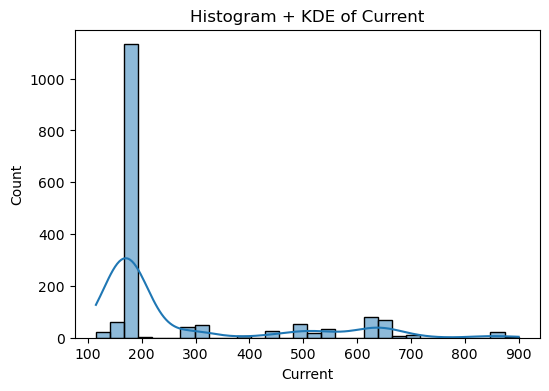

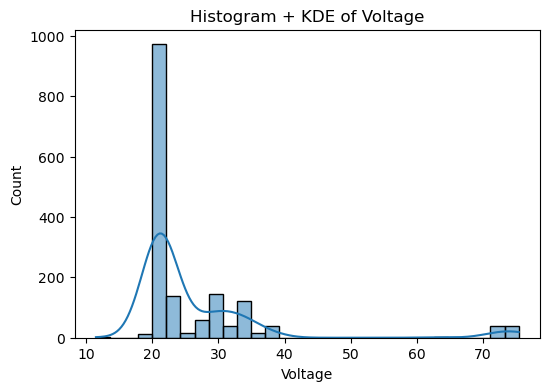

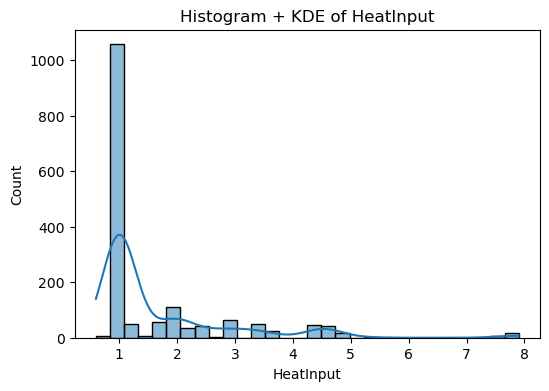

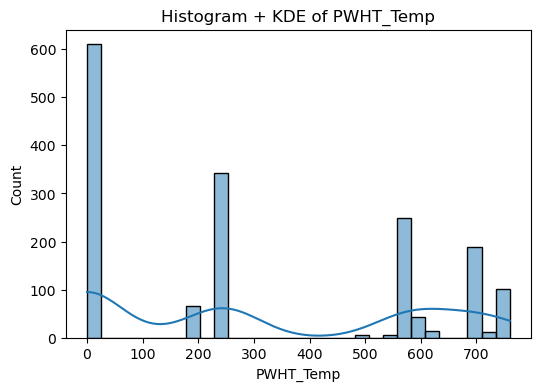

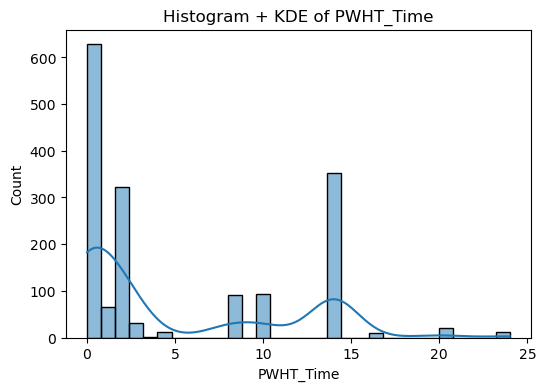

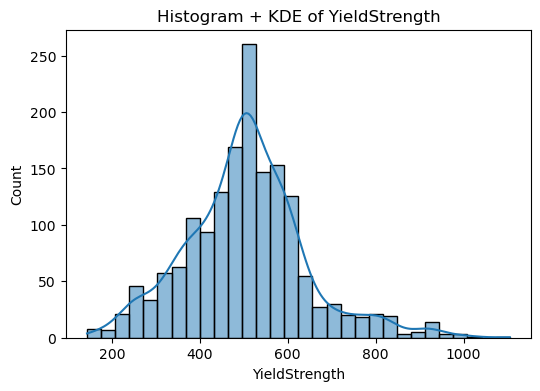

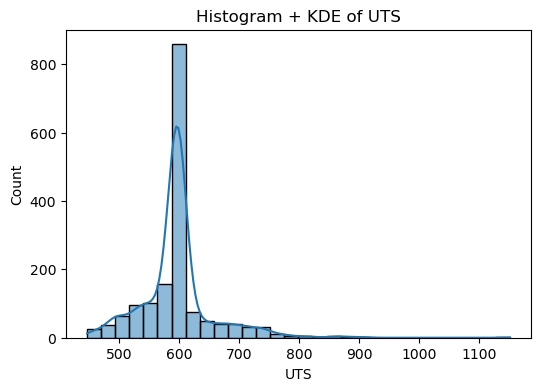

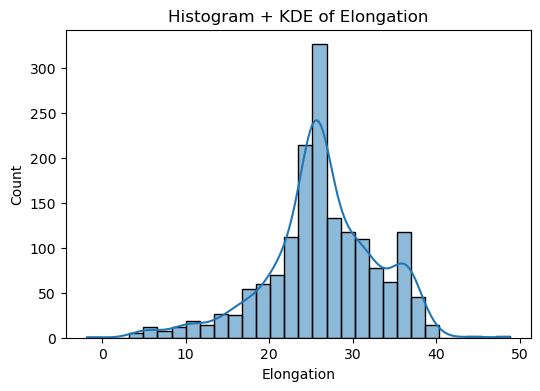

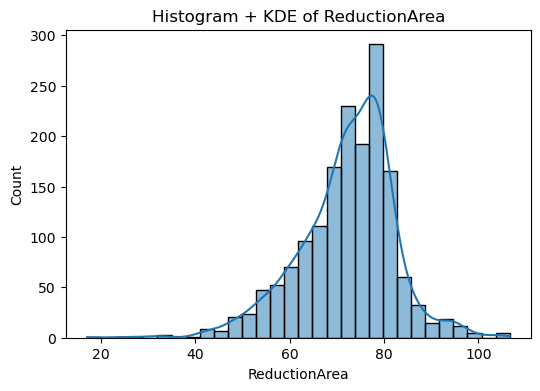

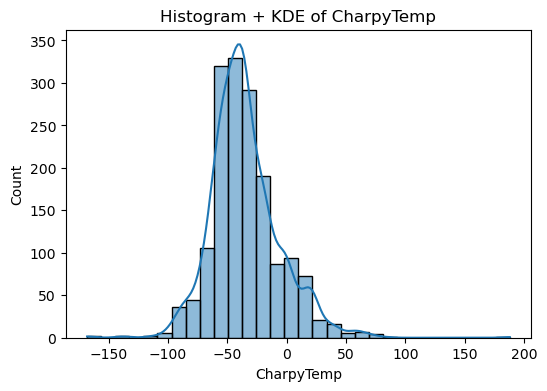

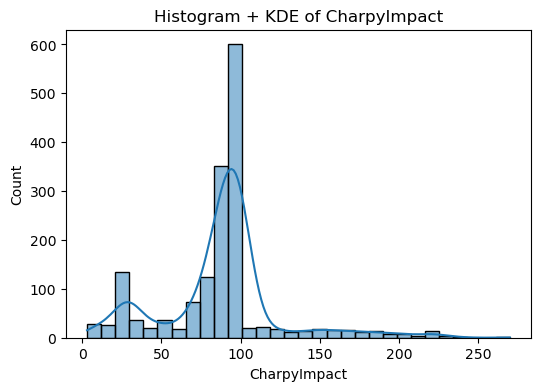

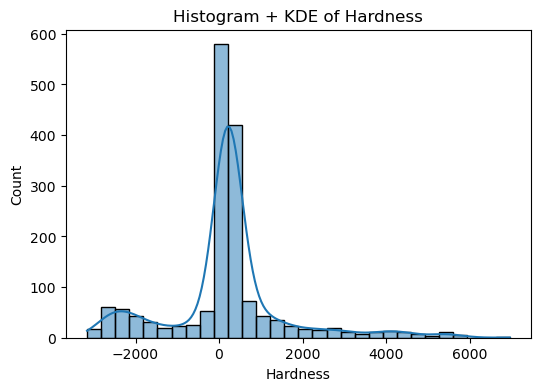

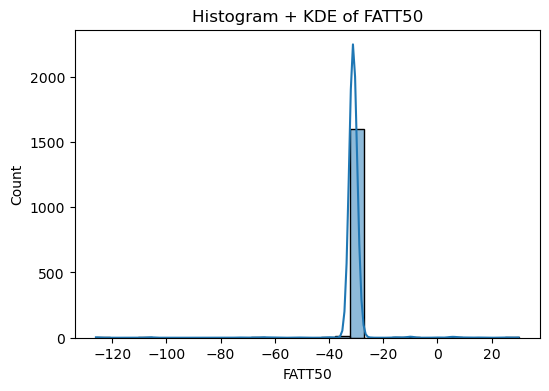

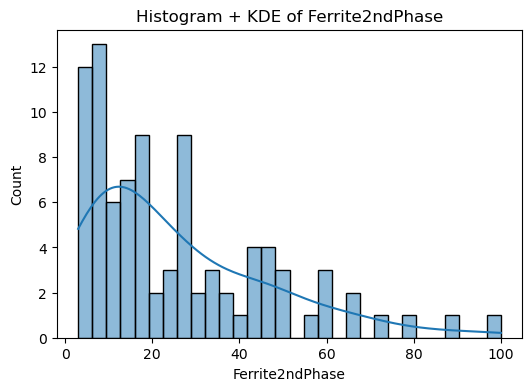

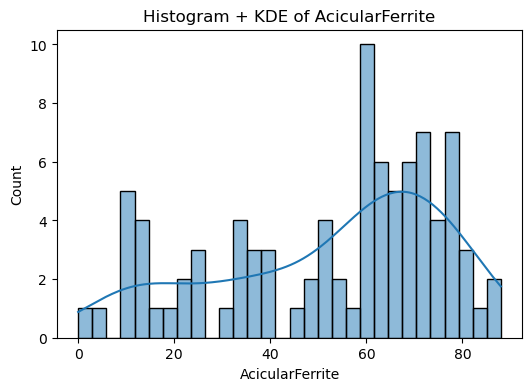

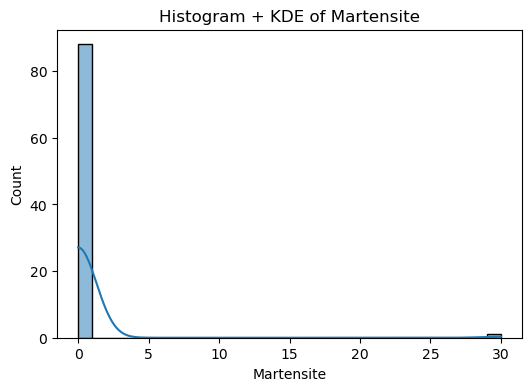

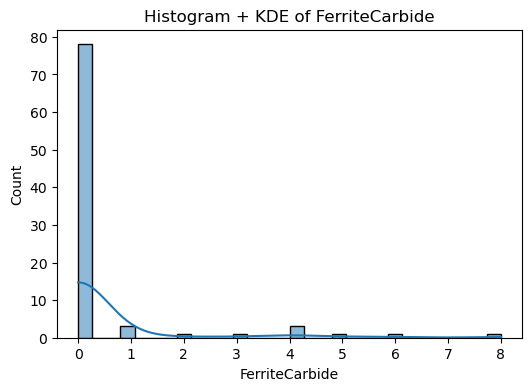

In [95]:
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Histogram + KDE of {col}')
    plt.show()

In [96]:
skewness = df[numeric_cols].skew()
skewness.sort_values(ascending=False)

V                  12.668854
P                  10.805622
S                   9.703553
Martensite          9.433981
Sn                  5.659366
FerriteCarbide      3.616863
B                   3.397389
N                   3.185140
Voltage             3.129640
Ti                  3.045889
Nb                  3.036061
Cu                  3.008974
Co                  2.787305
HeatInput           2.411818
Cr                  2.402170
Al                  2.311339
Ni                  1.711736
Current             1.686419
W                   1.657217
Si                  1.620403
UTS                 1.437551
Ferrite2ndPhase     1.264260
As                  1.249975
PWHT_Time           0.879038
C                   0.843511
Hardness            0.774952
CharpyTemp          0.760724
CharpyImpact        0.660050
Mo                  0.605350
YieldStrength       0.460202
PWHT_Temp           0.270639
Mn                  0.097503
Elongation         -0.498196
ReductionArea      -0.614747
AcicularFerrit

**Strategy**:
- Highly positively skewed: skew > 1 → consider log transform
- Moderately skewed: 0.5 < skew < 1 → optional
- Symmetric: -0.5 < skew < 0.5 → no transform
- Negatively skewed: skew < -1 → consider reflection + log / other transform


We'll logtransform highly positive skews

In [ ]:
log_cols = ['V', 'P', 'S', 'Sn', 'B', 'N', 'Voltage', 'Ti', 'Nb', 'Cu']

for col in log_cols:
    df[col+'_log'] = np.log1p(df[col])

c:\Users\clemm\miniconda3\envs\apprauto-env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [107]:
df.describe()

,C,Si,Mn,S,P,Ni,Cr,Mo,V,Cu,...,V_log,P_log,S_log,Sn_log,B_log,N_log,Voltage_log,Ti_log,Nb_log,Cu_log
count,1639.000000,1639.000000,1639.000000,1639.000000,1639.000000,1639.000000,1639.000000,1639.000000,1639.000000,1639.000000,...,1639.000000,1639.000000,1639.000000,1514.000000,1616.000000,1639.000000,1639.000000,1636.000000,1638.000000,1639.000000
mean,0.075175,0.328603,1.200134,0.009481,0.012948,0.475521,1.588588,0.428598,0.083858,0.164483,...,0.062537,0.012700,0.009378,3.715839,2.214794,4.548779,3.259991,4.016522,3.946010,0.137735
std,0.023635,0.112800,0.382271,0.011227,0.019642,0.612673,2.249508,0.361248,0.372279,0.222313,...,0.144062,0.017639,0.010571,1.291313,0.539974,0.504506,0.298765,1.081326,1.608449,0.163347
min,0.029000,0.040000,0.270000,0.001000,0.002000,-1.308202,-0.542971,-0.332158,-0.130994,-0.327498,...,-0.140405,0.001998,0.001000,-4.217442,-2.091892,3.091042,2.525729,0.000000,0.000000,-0.396751
25%,0.061000,0.270000,0.930000,0.006000,0.007000,0.060000,0.082572,0.151862,0.000500,0.020000,...,0.000500,0.006976,0.005982,3.866741,1.791759,4.309393,3.091042,3.637586,1.945910,0.019803
50%,0.074000,0.320000,1.250000,0.007000,0.010000,0.442821,0.952473,0.362502,0.050000,0.159022,...,0.048790,0.009950,0.006976,4.066649,2.243243,4.488636,3.091042,4.406473,4.540302,0.147577
75%,0.084000,0.360000,1.440000,0.010000,0.014000,0.684598,2.070000,0.608959,0.083000,0.226618,...,0.079735,0.013903,0.009950,4.331571,2.430897,4.700886,3.401197,4.567054,4.907634,0.204260
max,0.180000,1.140000,2.250000,0.140000,0.250000,3.500000,10.200000,1.500000,5.000000,1.630000,...,1.791759,0.223144,0.131028,6.908755,4.248495,6.315358,4.335459,6.538140,6.908755,0.966984
